# Model Fixed Before Conditional Curve - Parametric Modulation Analysis
## Useful if you anticipate the amplitude of the response may be different for each stimulus dimension or will change over time
### PMOD -  Modulated regressor
### EVENT - Event regressor

In [1]:
from glob import glob
from scipy import stats
from math import sqrt
import nibabel as nb
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style="white")

sids = ['WMAZE_001', 'WMAZE_002', 'WMAZE_004', 'WMAZE_005', 'WMAZE_006',
        'WMAZE_007', 'WMAZE_008', 'WMAZE_009', 'WMAZE_010', 'WMAZE_012',
        'WMAZE_017', 'WMAZE_018', 'WMAZE_019', 'WMAZE_020', 'WMAZE_021',
        'WMAZE_022', 'WMAZE_023', 'WMAZE_024', 'WMAZE_026', 'WMAZE_027']
proj_dir = '/home/data/madlab/Mattfeld_WMAZE/' 
mask_files = []
cope_files = []

for i, SID in enumerate(sids):
    mask_files_glob = glob(proj_dir+'derivatives/roi_masks/hamm/anat_masks/_subject_id_' + SID + '/_anatmask_xfm*/*')
    mask_files.append(sorted(mask_files_glob))
    rsc_files_glob = glob(proj_dir + 'derivatives/roi_masks/rsc_inepi/' +SID+ '/rsc_temp2epi/_subject_id_' 
                          +SID+ '/_targ2EPI*/*')
    mask_files[i].append(rsc_files_glob[0])
    subjcopes_glob = glob(proj_dir+'Hamm_Learning/PMA/lvl2/fixed/' + SID + '/fixedfx/cope_*')
    cope_files.append(sorted(subjcopes_glob))
    if len(cope_files[-1]) == 0 or len(cope_files[-1]) != 4:
        print(SID), len(cope_files[-1])

## Cell to double-check the array indexing

In [2]:
for i, curr_mask in enumerate(mask_files[0]):
    print(i, mask_files[0][i].split('/')[-1][:-7])

0 lh-all_mPFC_warped
1 lh-dlPFC_warped
2 lh-dmPFC_warped
3 lh-hippocampus_warped
4 lh-mPFC_fs-3reg_warped
5 lh-mPFC_fs_warped
6 lh-mPFC_lausanne_warped
7 lh-motor_warped
8 lh-parsT_warped
9 lh_caudate_anat_mask_warped
10 lh_insula_warped
11 lh_vocc_warped
12 rh_caudate_anat_mask_warped
13 rh-all_mPFC_warped
14 rh-dlPFC_warped
15 rh-dmPFC_warped
16 rh-hippocampus_warped
17 rh-mPFC_fs-3reg_warped
18 rh-mPFC_fs_warped
19 rh-mPFC_lausanne_warped
20 rh-motor_warped
21 rh-parsT_warped
22 rh_insula_warped
23 rh_vocc_warped
24 lh-putamen_warped
25 lh_dlpfc_warped
26 lh_dlpfc_warped
27 rh-putamen_warped
28 CCOPY_T_wmaze_template_trans


In [3]:
for i, curr_cope in enumerate(cope_files[0]):
    print(i, cope_files[5][i].split('/')[-1][5:-7]) 

0 AllVsBase
1 all_remaining
2 event
3 pmod


### Use binarized mask to obtain activation in left & right hemisphere for each region of interest

In [4]:
all_data = {'subjid':[],
            'lhhp_event':[], 'rhhp_event':[], 'lhhp_pmod':[], 'rhhp_pmod':[], #HPC
            'lhmpfc_event':[], 'rhmpfc_event':[], 'lhmpfc_pmod':[], 'rhmpfc_pmod':[], #mPFC
            'lhcaud_event':[], 'rhcaud_event':[], 'lhcaud_pmod':[], 'rhcaud_pmod':[], #caudate
            'lhput_event':[], 'rhput_event':[], 'lhput_pmod':[], 'rhput_pmod':[], #putamen
            'lhvocc_event':[], 'rhvocc_event':[], 'lhvocc_pmod':[], 'rhvocc_pmod':[]} #ventral occipital

for i in range(len(sids)):
    all_data['subjid'].append(sids[i])
    lh_hp_img = nb.load(mask_files[i][3]) #masks
    rh_hp_img = nb.load(mask_files[i][16])
    lh_mpfc_img = nb.load(mask_files[i][5])
    rh_mpfc_img = nb.load(mask_files[i][18])
    lh_caud_img = nb.load(mask_files[i][9])
    rh_caud_img = nb.load(mask_files[i][12])
    lh_put_img = nb.load(mask_files[i][24])
    rh_put_img = nb.load(mask_files[i][27])
    lh_vocc_img = nb.load(mask_files[i][11])
    rh_vocc_img = nb.load(mask_files[i][23])
    
    event_img = nb.load(cope_files[i][2]) #copes
    pmod_img = nb.load(cope_files[i][3])
    
    region = ['hp', 'mpfc', 'caud', 'put', 'vocc']
    contrasts = ['event', 'pmod']
   
    for r in region:
        for c in contrasts:
            lh_data = eval('{0}_img.get_data()[lh_{1}_img.get_data() > 0.]'.format(c,r))
            all_data['lh{0}_{1}'.format(r,c)].append(np.mean(lh_data))            
            rh_data = eval('{0}_img.get_data()[rh_{1}_img.get_data() > 0.]'.format(c,r))
            all_data['rh{0}_{1}'.format(r,c)].append(np.mean(rh_data))

all_data_df = pd.DataFrame(all_data)    

<string>:1: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


### Combine the two hemispheres to create one regional average

In [5]:
plot = {}
region = ['hp', 'mpfc', 'caud', 'put', 'vocc']
contrasts = ['event', 'pmod']

for r in region:
    for c in contrasts:
        all_data_df['{0}_all_{1}'.format(r,c)] = (all_data_df['lh{0}_{1}'.format(r,c)]+all_data_df['rh{0}_{1}'.format(r,c)])/2.
        plot['{0}_{1}'.format(r,c)] = all_data_df['{0}_all_{1}'.format(r,c)]
plot_df = pd.DataFrame.from_dict(plot)

## Hippocampus

In [6]:
hp_chart = {}
for x in ['event', 'pmod']:
    hp_chart['{0}'.format(x)] = all_data_df['hp_all_{0}'.format(x)] 
hp_chart_df = pd.DataFrame.from_dict(hp_chart)

Mean pmod:  2.9369678385555744
STD pmod:  9.259512440289752

Mean event:  -3.4515942096710206
STD event:  7.490349834235896

Wilcoxon (49.0, 0.03623390197753906) <---- **
Cohen's d =  1.045657763904545


<ipython-input-7-8b491865f482>:12: MatplotlibDeprecationWarning: Setting whis to 'range' is deprecated since 3.2 and support for it will be removed two minor releases later; set it to [0, 100] to achieve the same effect.
  ax.boxplot(allsubjs, whis='range', positions=ind, widths=0.15, patch_artist=True,


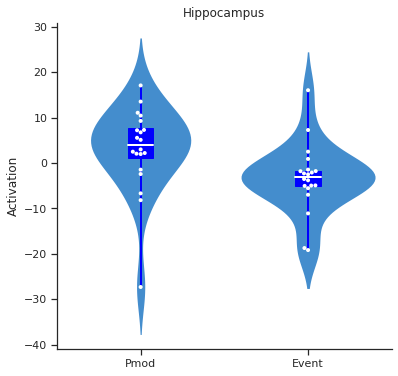

In [7]:
for d in ['pmod', 'event']:
    print("Mean {0}: ".format(d), np.mean(hp_chart['{0}'.format(d)]))
    print("STD {0}: ".format(d), np.std(hp_chart['{0}'.format(d)]))
    print("")
N = 2
conditions = ['Pmod', 'Event']
allsubjs = [hp_chart['pmod'], hp_chart['event']]
ind = np.arange(N)
fig, ax = plt.subplots(figsize = (6,6))
sns.despine(top=True)
sns.violinplot(data=allsubjs, color="#278fea", inner=None, linewidth=0, saturation=0.7)
ax.boxplot(allsubjs, whis='range', positions=ind, widths=0.15, patch_artist=True,
           showcaps=False, boxprops=dict(color="blue", facecolor="blue"),
           whiskerprops=dict(color="blue", linewidth=2, linestyle = "-"),
           medianprops=dict(color="w", linewidth=2))
sns.swarmplot(data = allsubjs, size = 4, color = "white", edgecolor = "gray")
ax.set_xticklabels(conditions)
ax.set_ylabel("Activation")
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_title("Hippocampus")
#use Shapiro test to determine normality of Run1 and Run2 distributions
if stats.shapiro(hp_chart['event'])[1] < 0.049 or stats.shapiro(hp_chart['pmod'])[1] < 0.049:
    #add visual indicators if nonparametric test is significant
    if stats.wilcoxon(hp_chart['pmod'], hp_chart['event'])[:][-1] < 0.049: #correction for multi comparisons
        print('Wilcoxon', stats.wilcoxon(hp_chart['pmod'], hp_chart['event'])[:], '<---- **')
    else:
        print('Wilcoxon', stats.wilcoxon(hp_chart['pmod'], hp_chart['event'])[:])
else: #normal distributions
    if stats.ttest_rel(hp_chart['pmod'], hp_chart['event'])[:][-1] < 0.049: #correction for multi comparisons
        print('t-test', stats.ttest_rel(hp_chart['pmod'], hp_chart['event'])[:], '<---- **')
    else:
        print('t-test', stats.ttest_rel(hp_chart['pmod'], hp_chart['event'])[:]  )      
cohens_d = ((np.average(hp_chart['pmod'])-np.average(hp_chart['event'])) 
            /(sqrt((np.std(hp_chart['pmod'],ddof=1))**2+np.std(hp_chart['event'],ddof=1)**2)/2))
print("Cohen's d = ", cohens_d) 

#plt.savefig("/home/arenf001/figs/PMA_F_HPC.png", dpi = 1000)
plt.show()

## Caudate

In [8]:
caud_chart = {}
for x in ['event', 'pmod']:
    caud_chart['{0}'.format(x)] = all_data_df['caud_all_{0}'.format(x)] 
caud_chart_df = pd.DataFrame.from_dict(caud_chart)

Mean pmod:  -10.339068669080735
STD pmod :  10.632576856552259

Mean event:  9.476689941063523
STD event :  9.394195582907145

t-test (-4.385674693535184, 0.00031791065584371297) <---- **
Cohen's d =  -2.722562184396804


<ipython-input-9-c95bbae96501>:12: MatplotlibDeprecationWarning: Setting whis to 'range' is deprecated since 3.2 and support for it will be removed two minor releases later; set it to [0, 100] to achieve the same effect.
  ax.boxplot(allsubjs, whis='range', positions=ind, widths=0.15, patch_artist=True,


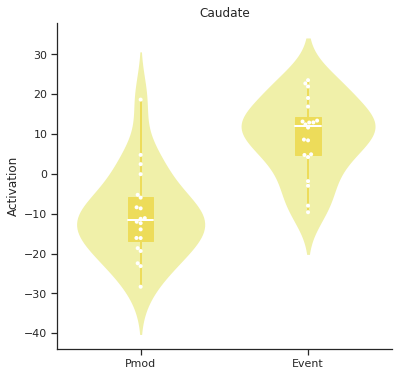

In [9]:
for d in ['pmod', 'event']:
    print("Mean {0}: ".format(d), np.mean(caud_chart['{0}'.format(d)]))
    print("STD {0} : ".format(d), np.std(caud_chart['{0}'.format(d)]))
    print("")
N = 2
conditions = ['Pmod', 'Event']
allsubjs = [caud_chart['pmod'], caud_chart['event']]
ind = np.arange(N)
fig, ax = plt.subplots(figsize = (6,6))
sns.despine(top=True)
sns.violinplot(data=allsubjs, color="#fcfc9d", inner=None, linewidth=0)
ax.boxplot(allsubjs, whis='range', positions=ind, widths=0.15, patch_artist=True,
           showcaps=False, boxprops=dict(color="#eddc5a", facecolor="#eddc5a"),
           whiskerprops=dict(color="#eddc5a", linewidth=2, linestyle = "-"), 
           medianprops=dict(color="w", linewidth=2))
sns.swarmplot(data = allsubjs, size = 4, color = "white", edgecolor = "gray")
ax.set_xticklabels(conditions)
ax.set_ylabel("Activation")
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_title("Caudate")
#use Shapiro test to determine normality of Run1 and Run2 distributions
if stats.shapiro(caud_chart['event'])[1] < 0.049 or stats.shapiro(caud_chart['pmod'])[1] < 0.049:
    #add visual indicators if nonparametric test is significant
    if stats.wilcoxon(caud_chart['pmod'], caud_chart['event'])[:][-1] < 0.049: #correction for multi comparisons
        print('Wilcoxon', stats.wilcoxon(caud_chart['pmod'], caud_chart['event'])[:], '<---- **')
    else:
        print('Wilcoxon', stats.wilcoxon(caud_chart['pmod'], caud_chart['event'])[:])
else: #normal distributions
    if stats.ttest_rel(caud_chart['pmod'], caud_chart['event'])[:][-1] < 0.049: #correction for multi comparisons
        print('t-test', stats.ttest_rel(caud_chart['pmod'], caud_chart['event'])[:], '<---- **')
    else:
        print('t-test', stats.ttest_rel(caud_chart['pmod'], caud_chart['event'])[:])        
cohens_d = ((np.average(caud_chart['pmod'])-np.average(caud_chart['event'])) 
            /(sqrt((np.std(caud_chart['pmod'],ddof=1))**2+np.std(caud_chart['event'],ddof=1)**2)/2))
print("Cohen's d = ", cohens_d) 
#plt.savefig("/home/arenf001/figs/PMA_F_caud.png", dpi = 1000)
plt.show()

## mPFC

In [10]:
mpfc_chart = {}
for x in ['event', 'pmod']:
    mpfc_chart['{0}'.format(x)] = all_data_df['mpfc_all_{0}'.format(x)] 
mpfc_chart_df = pd.DataFrame.from_dict(mpfc_chart)

Mean pmod:  2.0623289961367846
STD pmod :  6.303980112273235

Mean event:  -2.087043343484402
STD event :  7.13606849515624



<ipython-input-11-65faf2c5418f>:12: MatplotlibDeprecationWarning: Setting whis to 'range' is deprecated since 3.2 and support for it will be removed two minor releases later; set it to [0, 100] to achieve the same effect.
  ax.boxplot(allsubjs, whis='range', positions=ind, widths=0.15, patch_artist=True,


t-test (1.487988814593898, 0.15316340412638388)
Cohen's d =  0.8494887524439554


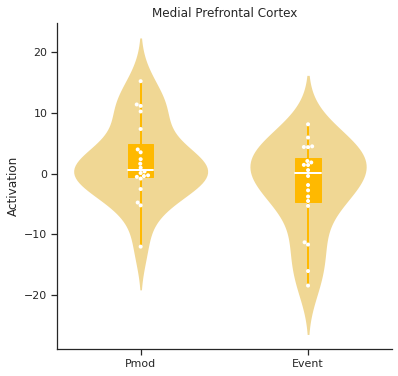

In [11]:
for d in ['pmod', 'event']:
    print("Mean {0}: ".format(d), np.mean(mpfc_chart['{0}'.format(d)]))
    print("STD {0} : ".format(d), np.std(mpfc_chart['{0}'.format(d)]))
    print("")
N = 2
conditions = ['Pmod', 'Event']
allsubjs = [mpfc_chart['pmod'], mpfc_chart['event']]
ind = np.arange(N)
fig, ax = plt.subplots(figsize = (6,6))
sns.despine(top=True)
sns.violinplot(data=allsubjs, color="#ffde85", inner=None, linewidth=0)
ax.boxplot(allsubjs, whis='range', positions=ind, widths=0.15, patch_artist=True,
           showcaps=False, boxprops=dict(color="#ffb900", facecolor="#ffb900"),
           whiskerprops=dict(color="#ffb900", linewidth=2, linestyle = "-"), 
           medianprops=dict(color="w", linewidth=2))
sns.swarmplot(data = allsubjs, size = 4, color = "white", edgecolor = "gray")
ax.set_xticklabels(conditions)
ax.set_ylabel("Activation")
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_title("Medial Prefrontal Cortex")
#use Shapiro test to determine normality of Run1 and Run2 distributions
if stats.shapiro(mpfc_chart['event'])[1] < 0.049 or stats.shapiro(mpfc_chart['pmod'])[1] < 0.049:
    #add visual indicators if nonparametric test is significant
    if stats.wilcoxon(mpfc_chart['pmod'], mpfc_chart['event'])[:][-1] < 0.049: #correction for multi comparisons
        print('Wilcoxon', stats.wilcoxon(mpfc_chart['pmod'], mpfc_chart['event'])[:], '<---- **')
    else:
        print('Wilcoxon', stats.wilcoxon(mpfc_chart['pmod'], mpfc_chart['event'])[:])
else: #normal distributions
    if stats.ttest_rel(mpfc_chart['pmod'], mpfc_chart['event'])[:][-1] < 0.049: #correction for multi comparisons
        print('t-test', stats.ttest_rel(mpfc_chart['pmod'], mpfc_chart['event'])[:], '<---- **')
    else:
        print('t-test', stats.ttest_rel(mpfc_chart['pmod'], mpfc_chart['event'])[:])       
cohens_d = ((np.average(mpfc_chart['pmod'])-np.average(mpfc_chart['event'])) 
            /(sqrt((np.std(mpfc_chart['pmod'],ddof=1))**2+np.std(mpfc_chart['event'],ddof=1)**2)/2))
print("Cohen's d = ", cohens_d) 
#plt.savefig("/home/arenf001/figs/PMA_F_mpfc.png", dpi = 1000)
plt.show()

## Putamen

In [12]:
put_chart = {}
for x in ['event', 'pmod']:
    put_chart['{0}'.format(x)] = all_data_df['put_all_{0}'.format(x)] 
put_chart_df = pd.DataFrame.from_dict(put_chart)

Mean pmod:  -2.845938176475465
STD pmod :  9.095511271248753

Mean event:  2.1512715578079225
STD event :  8.168644350788567

t-test (-1.3097766421925359, 0.20588803912158815)
Cohen's d =  -0.7968269991272813


<ipython-input-13-51fcabcf1f9b>:12: MatplotlibDeprecationWarning: Setting whis to 'range' is deprecated since 3.2 and support for it will be removed two minor releases later; set it to [0, 100] to achieve the same effect.
  ax.boxplot(allsubjs, whis='range', positions=ind, widths=0.15, patch_artist=True,


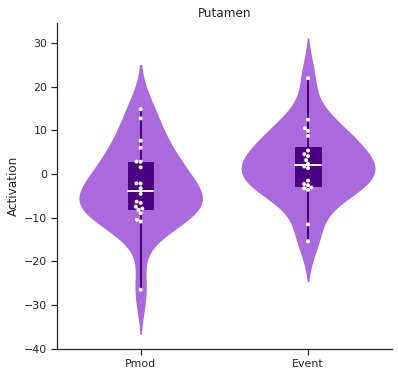

In [13]:
for d in ['pmod', 'event']:
    print("Mean {0}: ".format(d), np.mean(put_chart['{0}'.format(d)]))
    print("STD {0} : ".format(d), np.std(put_chart['{0}'.format(d)]))
    print("")
N = 2
conditions = ['Pmod', 'Event']
allsubjs = [put_chart['pmod'], put_chart['event']]
ind = np.arange(N)
fig, ax = plt.subplots(figsize = (6,6))
sns.despine(top=True)
sns.violinplot(data=allsubjs, color="#af52f4", inner=None, linewidth=0, saturation=0.7)
ax.boxplot(allsubjs, whis='range', positions=ind, widths=0.15, patch_artist=True,
           showcaps=False, boxprops=dict(color="indigo", facecolor="indigo"),
           whiskerprops=dict(color="indigo", linewidth=2, linestyle = "-"),
           medianprops=dict(color="w", linewidth=2))
sns.swarmplot(data = allsubjs, size = 4, color = "white", edgecolor = "gray")
ax.set_xticklabels(conditions)
ax.set_ylabel("Activation")
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_title("Putamen")
#use Shapiro test to determine normality of Run1 and Run2 distributions
if stats.shapiro(put_chart['event'])[1] < 0.049 or stats.shapiro(put_chart['pmod'])[1] < 0.049:
    #add visual indicators if nonparametric test is significant
    if stats.wilcoxon(put_chart['pmod'], put_chart['event'])[:][-1] < 0.049: #correction for multi comparisons
        print('Wilcoxon', stats.wilcoxon(put_chart['pmod'], put_chart['event'])[:], '<---- **')
    else:
        print('Wilcoxon', stats.wilcoxon(put_chart['pmod'], put_chart['event'])[:])
else: #normal distributions
    if stats.ttest_rel(put_chart['pmod'], put_chart['event'])[:][-1] < 0.049: #correction for multi comparisons
        print('t-test', stats.ttest_rel(put_chart['pmod'], put_chart['event'])[:], '<---- **')
    else:
        print('t-test', stats.ttest_rel(put_chart['pmod'], put_chart['event'])[:])     
cohens_d = ((np.average(put_chart['pmod'])-np.average(put_chart['event'])) 
            /(sqrt((np.std(put_chart['pmod'],ddof=1))**2+np.std(put_chart['event'],ddof=1)**2)/2))
print("Cohen's d = ", cohens_d)
#plt.savefig("/home/arenf001/figs/PMA_F_put.png", dpi = 1000)
plt.show()

## Ventral Occipital

In [14]:
vocc_chart = {}
for x in ['event', 'pmod']:
    vocc_chart['{0}'.format(x)] = all_data_df['vocc_all_{0}'.format(x)] 
vocc_chart_df = pd.DataFrame.from_dict(vocc_chart)

Mean pmod:  -4.605484567582607
STD pmod :  8.97748480701237

Mean event:  3.6365161523222924
STD event :  8.803263823575604



<ipython-input-15-6cd410f2a1fd>:12: MatplotlibDeprecationWarning: Setting whis to 'range' is deprecated since 3.2 and support for it will be removed two minor releases later; set it to [0, 100] to achieve the same effect.
  ax.boxplot(allsubjs, whis='range', positions=ind, widths=0.15, patch_artist=True,


t-test (-2.108361459835764, 0.04850385505035676) <---- **
Cohen's d =  -1.2778166873436578


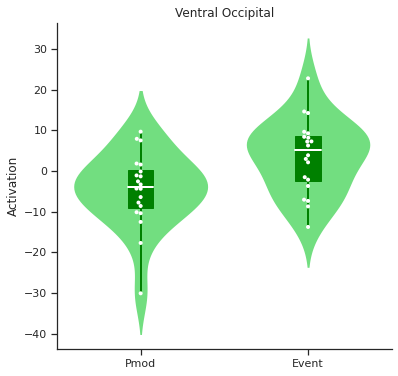

In [15]:
for d in ['pmod', 'event']:
    print("Mean {0}: ".format(d), np.mean(vocc_chart['{0}'.format(d)]))
    print("STD {0} : ".format(d), np.std(vocc_chart['{0}'.format(d)]))
    print("")
N = 2
conditions = ['Pmod', 'Event']
allsubjs = [vocc_chart['pmod'], vocc_chart['event']]
ind = np.arange(N)
fig, ax = plt.subplots(figsize = (6,6))
sns.despine(top=True)
sns.violinplot(data=allsubjs, color='#5bf56f', inner=None, linewidth=0, saturation=0.7)
ax.boxplot(allsubjs, whis='range', positions=ind, widths=0.15, patch_artist=True,
           showcaps=False, boxprops=dict(color='green', facecolor='green'),
           whiskerprops=dict(color='green', linewidth=2, linestyle = '-'),
           medianprops=dict(color='w', linewidth=2))
sns.swarmplot(data = allsubjs, size = 4, color = "white", edgecolor = "gray")
ax.set_xticklabels(conditions)
ax.set_ylabel("Activation")
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_title("Ventral Occipital")
#use Shapiro test to determine normality of Run1 and Run2 distributions
if stats.shapiro(vocc_chart['event'])[1] < 0.049 or stats.shapiro(vocc_chart['pmod'])[1] < 0.049:
    #add visual indicators if nonparametric test is significant
    if stats.wilcoxon(vocc_chart['pmod'], vocc_chart['event'])[:][-1] < 0.049: #correction for multi comparisons
        print('Wilcoxon', stats.wilcoxon(vocc_chart['pmod'], vocc_chart['event'])[:], '<---- **')
    else:
        print('Wilcoxon', stats.wilcoxon(vocc_chart['pmod'], vocc_chart['event'])[:])
else: #normal distributions
    if stats.ttest_rel(vocc_chart['pmod'], vocc_chart['event'])[:][-1] < 0.049: #correction for multi comparisons
        print('t-test', stats.ttest_rel(vocc_chart['pmod'], vocc_chart['event'])[:], '<---- **')
    else:
        print('t-test', stats.ttest_rel(vocc_chart['pmod'], vocc_chart['event'])[:])        
cohens_d = ((np.average(vocc_chart['pmod'])-np.average(vocc_chart['event'])) 
            /(sqrt((np.std(vocc_chart['pmod'],ddof=1))**2+np.std(vocc_chart['event'],ddof=1)**2)/2))
print("Cohen's d = ", cohens_d)
#plt.savefig("/home/arenf001/figs/PMA_F_vocc.png", dpi = 1000)
plt.show()